# 531 Lec 7 - Trendlines and confidence intervals

Lecture learning goals

By the end of the lecture you will be able to:

1. Visualize pair-wise differences using a slope plot.
2. Visualize trends using regression and loess lines.
3. Create and understand how to interpret confidence intervals and confidence bands.
4. Telling a story with data (reading only)

## Required readings

This lecture's readings are both from Fundamentals of Data Visualization.

- [Section 14 - 14.2 on visualizing trends.](https://clauswilke.com/dataviz/visualizing-trends.html)
- [Section 16 on visualizing uncertainty](https://clauswilke.com/dataviz/visualizing-uncertainty.html) (some of this will be repetition from 552).

Table of Contents

You can view the ToC by opening this in your local Jupyter Lab,
and downloading the ToC extension
by going to the Extension Manager tab in the left sidebar, searching for "toc", and clicking "install"
(I posted [a video about this on slack](https://ubc-mds.slack.com/archives/C24GEJS11/p1599940203406600) if you can't find the extension).

---

In [1]:
# Run this cell to ensure that altair plots show up in the exported HTML
# and that the R cell magic works
import altair as alt
import pandas as pd

# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable('mimetype')
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable('data_server')

# Load the R cell magic
%load_ext rpy2.ipython

Read in data

Let's start by looking at your results from the world health quiz we did in lab 1!
Below, I read in the data and assign a label for whether each student
had a positive or negative outlook of their own results
compared to their estimation of the class average.

In [2]:
%%R
library(tidyverse)

theme_set(theme_grey(base_size=18))

scores_raw <- read_csv('data/students-gapminder.csv')
colnames(scores_raw) <- c('time', 'student_score', 'estimated_score')
scores <- scores_raw %>%
    mutate(diff = student_score - estimated_score,
           estimation = case_when(
               diff == 0 ~ 'neutral',
               diff < 0 ~ 'negative',
               diff > 0 ~ 'positive')) %>%
    pivot_longer(!c(time, estimation, diff)) %>%
    arrange(desc(diff))
scores

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()




── Column specification ────────────────────────────────────────────────────────
cols(
  Timestamp = col_character(),
  `Please enter how many questions you answered correctly on the test (0 - 13)` = col_double(),
  `What do you think the average score among all MDS students was (0 - 13)?` = col_double()
)

# A tibble: 146 x 5
   time                       diff estimation name            value
   <chr>                     <dbl> <chr>      <chr>           <dbl>
 1 2020/10/15 2:08:51 PM MDT     2 positive   student_score       9
 2 2020/10/15 2:08:51 PM MDT     2 positive   estimated_score     7
 3 2020/10/15 3:38:21 PM MDT     2 positive   student_score       8
 4 2020/10/15 3:38:21 PM MDT     2 positive   estimated_score     6
 5 2020/10/17 7:54:24 AM MDT     2 positive   student_score       9
 6 2020/10/17 7:54:24 AM MDT     2 positive   estimated_score     7
 7 2020/10/18 4:36:32 PM MDT     2 positive   student_score      10
 8 2020/10/18 4:36:32 PM MDT     2 positive   estimated_sc

We could make a distribution plot,
such as a KDE for the students score and estimated class score.
From this plot we can see that on average students seemed to believe their classmates scored better,
but we don't know if this is because all students thought this,
or some thought their classmates scored much better while others thought it was about the same.

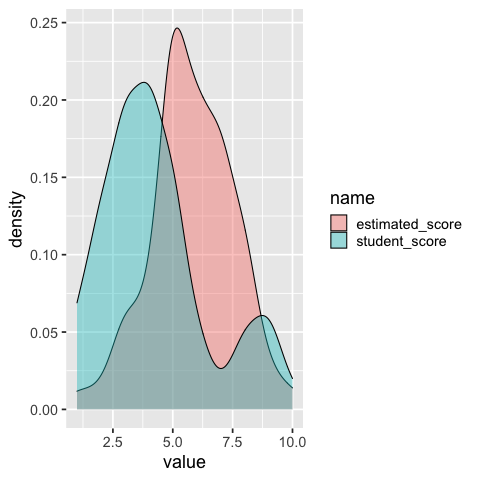

In [3]:
%%R 
ggplot(scores) +
    aes(x = value,
       fill = name) +
    geom_density(alpha=0.4)

## 1. Paired comparisons with slope plots

Drawing out each students score and estimated score,
and then connecting them with a line allows us to easily see
the trends in how many students thought their score was better or worse than the class.

### 1) ggplot

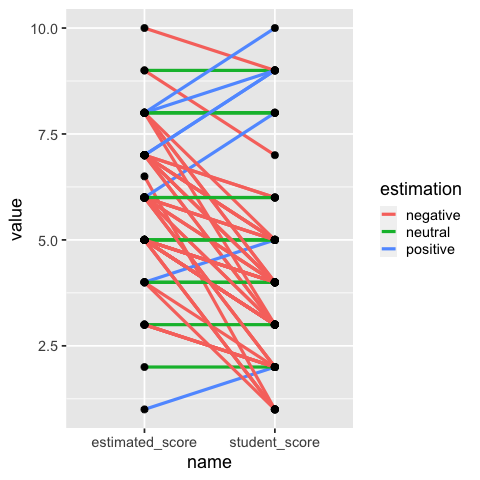

In [4]:
%%R -o scores
ggplot(scores) +
    aes(x = name,
        y = value,
       group = time) +
    geom_line(aes(color = estimation), size = 1.5) + 
    geom_point(size=3) 

#### diverging colormap

To make it easier to see how much better or worse each student score is compared to the class estimate,
we can color the lines by the difference and set a diverging colormap.

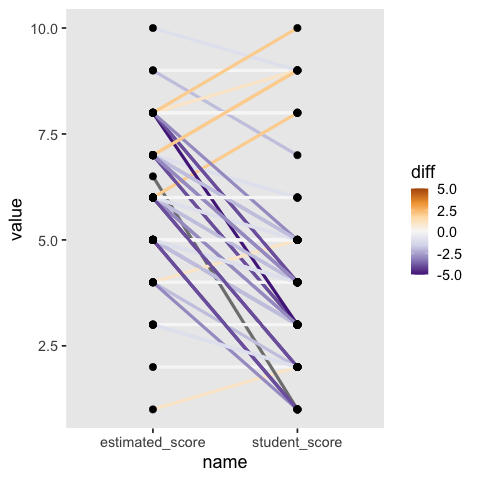

In [5]:
%%R -o scores
ggplot(scores) +
    aes(x = name,
        y = value,
       group = time) +
    geom_line(aes(color = diff), size = 1.5) +   # <-
    geom_point(size=3) +
    scale_color_distiller(palette = 'PuOr', lim = c(-5, 5)) + # <-
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank())

#### bar plot for diff
Another way we could have visualized these differences would have been as a bar plot of the differences,
but we would not know the students' score, just the difference.

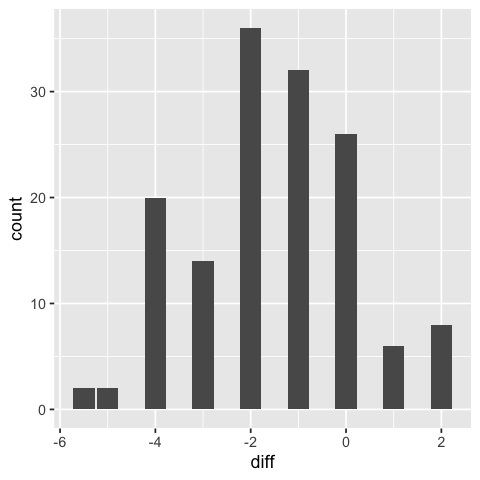

In [6]:
%%R
ggplot(scores) +
    aes(x = diff) +
    geom_bar()

#### scatter plot of diff
A scatter plot could also work for this comparison,
ideally with a diagonal line at zero difference.

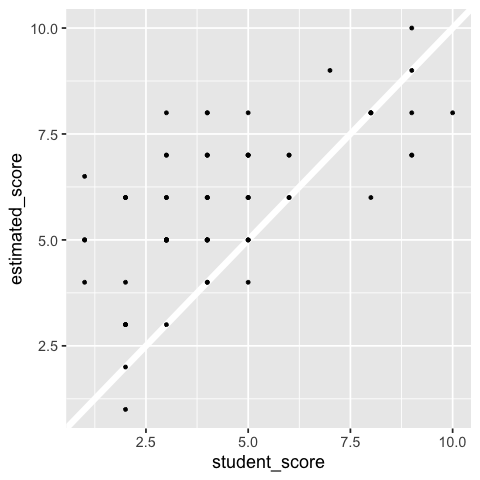

In [7]:
%%R
ggplot(scores_raw) +
    aes(x = student_score,
        y = estimated_score) +
    geom_abline(slope = 1, intercept = 0, color = 'white', size = 3) +
    geom_point()

### 2). Altair

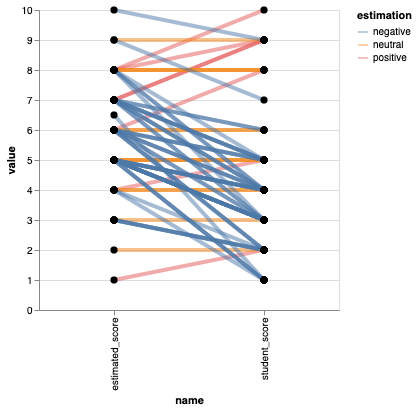

In [8]:
points = (
    alt.Chart(scores)
    .mark_circle(size=50, color="black", opacity=1)
    .encode(alt.X("name"), 
            alt.Y("value"), 
            alt.Detail("time")) # group without coloring
    .properties(width=300)
)


points.mark_line(size=4, opacity=0.5).encode(alt.Color("estimation")) + points

#### diverging colormap

To make it easier to see how much better or worse each student score is compared to the class estimate,
we can color the lines by the difference and set a diverging colormap.

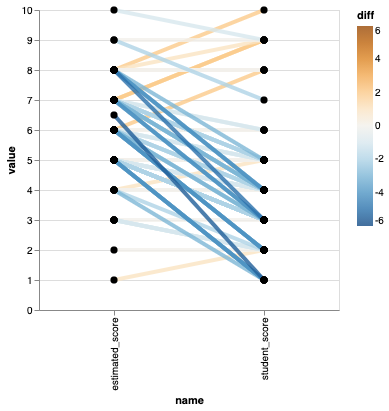

In [9]:
points = alt.Chart(scores).mark_circle(size=50, color='black', opacity=1).encode(
    alt.X('name'),
    alt.Y('value'),
    alt.Detail('time')).properties(width=300)
points.mark_line(size=4, opacity=0.8).encode(alt.Color('diff', scale=alt.Scale(scheme='blueorange', domain=(-6, 6)))) + points

## 2. Trendlines

Trendlines (also sometimes called "lines of best fit", or "fitted lines")
are good to highlight general trends in the data that can be hard to elucidate 
by looking at the raw data points.
This can happen if there are many data points or many groups inside the data.

### 1). Altair

In [10]:
from vega_datasets import data

cars = data.cars()
cars 

,Name,Miles_per_Gallon,Cylinders,Displacement,Horsepower,Weight_in_lbs,Acceleration,Year,Origin
0,chevrolet chevelle malibu,18.0,8,307.0,130.0,3504,12.0,1970-01-01,USA
1,buick skylark 320,15.0,8,350.0,165.0,3693,11.5,1970-01-01,USA
2,plymouth satellite,18.0,8,318.0,150.0,3436,11.0,1970-01-01,USA
3,amc rebel sst,16.0,8,304.0,150.0,3433,12.0,1970-01-01,USA
4,ford torino,17.0,8,302.0,140.0,3449,10.5,1970-01-01,USA
...,...,...,...,...,...,...,...,...,...
401,ford mustang gl,27.0,4,140.0,86.0,2790,15.6,1982-01-01,USA
402,vw pickup,44.0,4,97.0,52.0,2130,24.6,1982-01-01,Europe
403,dodge rampage,32.0,4,135.0,84.0,2295,11.6,1982-01-01,USA
404,ford ranger,28.0,4,120.0,79.0,2625,18.6,1982-01-01,USA


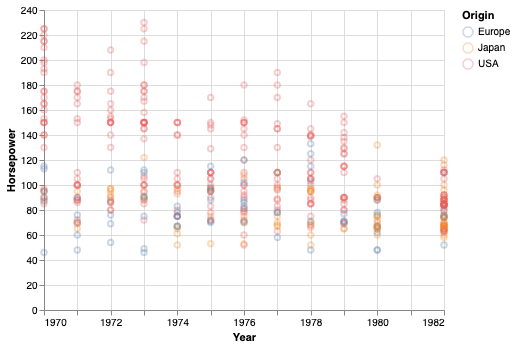

In [11]:
points = alt.Chart(cars).mark_point(opacity=0.3).encode(
    alt.X('Year'),
    alt.Y('Horsepower'),
    alt.Color('Origin')) 
points

A not so effective way to visualize the trend in this data is to connect all data points with a line.

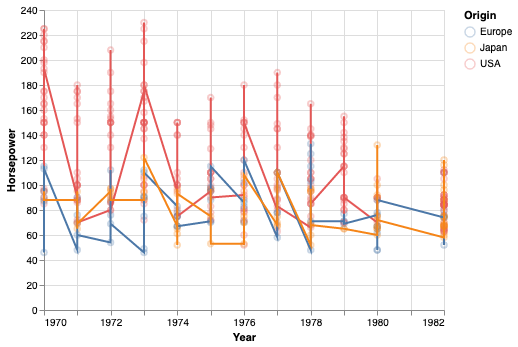

In [12]:
points + points.mark_line()

#### a line connect means
A simple way is to use the mean y-value at each x.
This works OK in hour case because each year has several values,
but in many cases with a continuous x-axis,
you would need to bin it in order to avoid noise from outliers.

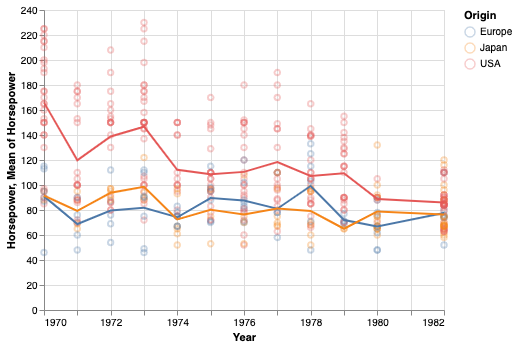

In [13]:
points + points.encode(y='mean(Horsepower)').mark_line()

#### transform_window (rolling mean)
An alternative to binning continuous data is to use a moving/rolling average,
that takes the mean of the last $n$ observations.
In our example here,
a moving average becomes a bit complicated because there are so many y-values for the exact same x-value,
so we would need to calculate the average for each year first,
and then move/roll over that,
which can be done using the `window_transform` method in Altair.
[A more common and simpler example can be viewed in the Altair docs.](https://altair-viz.github.io/gallery/scatter_with_rolling_mean.html)

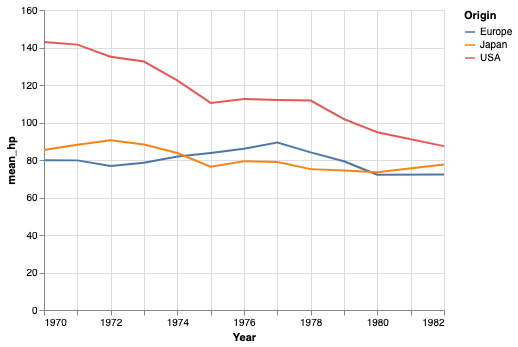

In [14]:
# This will not be on a quiz, I added it for those who are interested.
mean_per_year = cars.groupby(["Origin", "Year"])["Horsepower"].mean().reset_index()

(
    alt.Chart(mean_per_year)
    .transform_window(mean_hp="mean(Horsepower)", frame=[-1, 1], groupby=["Origin"])
    .mark_line()
    .encode(x="Year", y="mean_hp:Q", color="Origin")
)

We can also use the `rolling` method in pandas for this calculation,
but it handles the edges a bit differently.

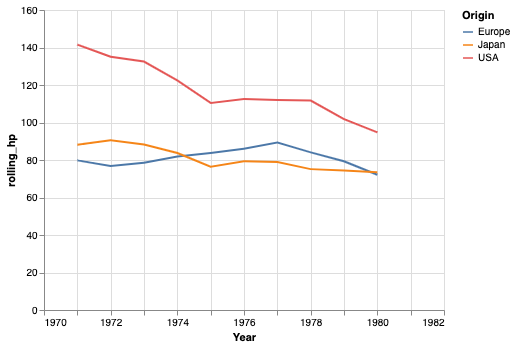

In [15]:
# This will not be on a quiz, I added it for those who are interested.
mean_per_year = cars.groupby(['Origin', 'Year'])['Horsepower'].mean().reset_index()
mean_per_year['rolling_hp'] = mean_per_year.groupby('Origin')['Horsepower'].rolling(3, center=True).mean().to_numpy()

alt.Chart(mean_per_year).mark_line().encode(
    x='Year',
    y='rolling_hp',
    color='Origin')

#### transform_regression
Another way of showing a trend in the data is via regression.
You will learn more about this later in the program,
but in brief you are fitting a straight line through the data,
by choosing the line that minimizes a certain cost function (or penalty),
commonly the sum squared deviations of the data to the line (least squares).

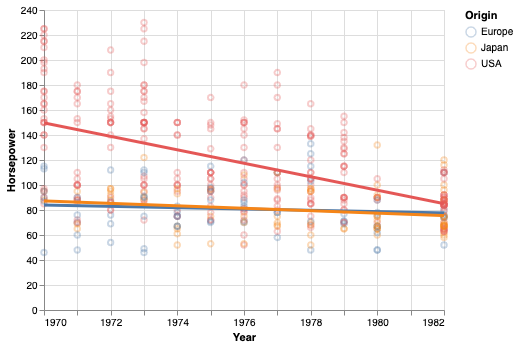

In [16]:
points +  points.transform_regression(
    'Year', 'Horsepower', groupby=['Origin']).mark_line(size=3)

You are not limited to fitting linear lines,
but can try fits that are quadratic, polynomial, etc.

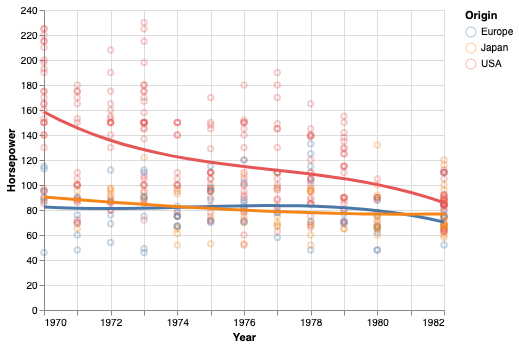

In [17]:
points +  points.transform_regression(
    'Year', 'Horsepower', groupby=['Origin'], method='poly').mark_line(size=3)

#### transform_loess
Sometimes it is difficult to find a single regression equation that describes the entire data set.
Instead,
you can fit multiple equations (usually linear and quadratic) to smaller subsets of the data,
and add them together to get the final line.
This is conceptually similar to a moving/rolling average,
which also only uses part of the data to create the trend line.

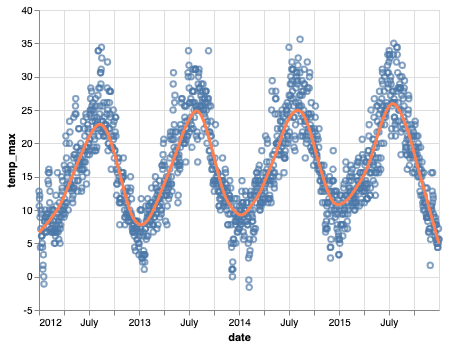

In [47]:
import altair as alt
from vega_datasets import data

points = alt.Chart(data.seattle_weather()).mark_point().encode(
    x=('date'),
    y=('temp_max'))

points + points.transform_loess('date', 'temp_max', bandwidth=0.1).mark_line(color='coral', size=3)


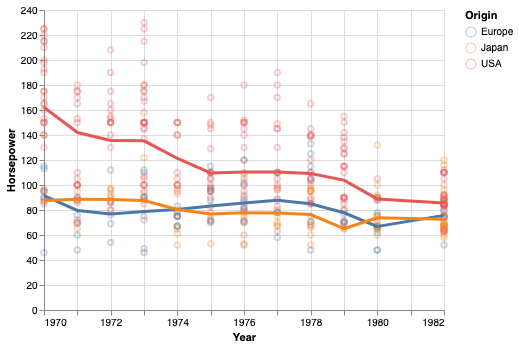

In [18]:
points +  points.transform_loess(
    'Year', 'Horsepower', groupby=['Origin']).mark_line(size=3)

The bandwidth parameter controls how much the loess fit should be influenced
by local variation in the data,
similar to the effect of the bandwidth parameter for a KDE.

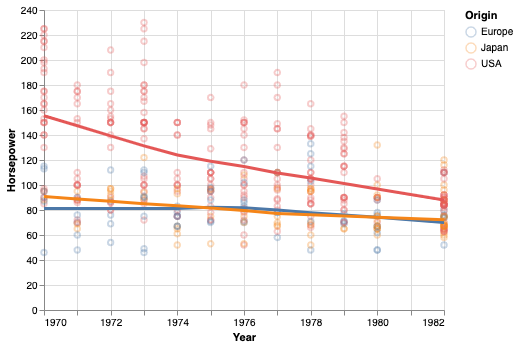

In [19]:
# The default is 0.3 and 1 is often close to a linear fit.
points +  points.transform_loess(
    'Year', 'Horsepower', groupby=['Origin'], bandwidth=0.8).mark_line(size=3)

#### When to choose which trendline?

> rolling mean
- If it is important that the line has values that are easy to interpret,
  choose a rolling mean.
  These are also the most straightforward trendlines
  when communicating data to a general audience.
  
> linear regression
- If you think a simple line equation (e.g. linear) describes your data well,
  this can be advantageous since you would know that your data follows a set pattern,
  and it is easy to predict how the data behaves outside the values you have collected
  (of course still with more uncertainty the further away from your data you predict).
  
  
> LOESS
- If you are mainly interested in highlighting a trend in the current data,
  and the two situations described above are not of great importance for your figure,
  then a loess line could be sutiabe.
  It has the advantage that it describes trends in data very "naturally",
  meaning that it highlights patterns we would tend to highlight ourselves in qualitative assessment.
  It also less strict in its statistical assumption compared to e.g. a linear regression,
  so you don't have to worry about finding the correct equation for the line,
  and assessing whether your data truly follows that equation globally.

### 2). ggplot

#### means
Using the mean as a trendline.

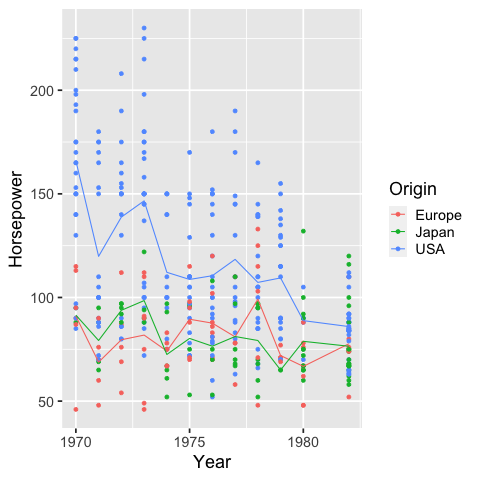

In [20]:
%%R -i cars
ggplot(cars) +
    aes(x = Year,
        y = Horsepower,
        color = Origin) +
    geom_point() +
    geom_line(stat = 'summary', fun = 'mean')

#### `geom_smooth` (LOESS)

`geom_smooth` creates a loess trendline by default.
The shaded gray area is the 95% confidence interval of the fitted line.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



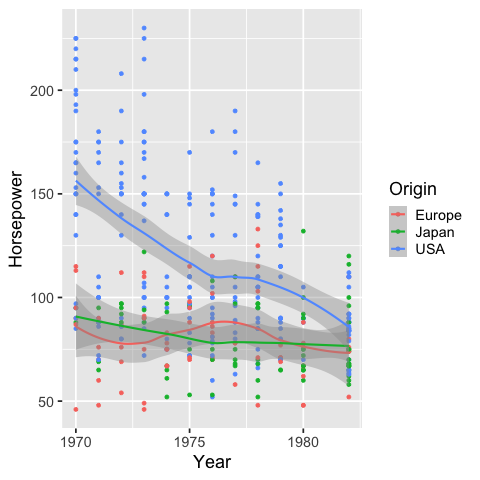

In [21]:
%%R -i cars
ggplot(cars) +
    aes(x = Year,
        y = Horsepower,
        color = Origin) +
    geom_point() +
    geom_smooth()

#### `geom_smooth` (colored CI)
We can color the confidence interval the same as the lines.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



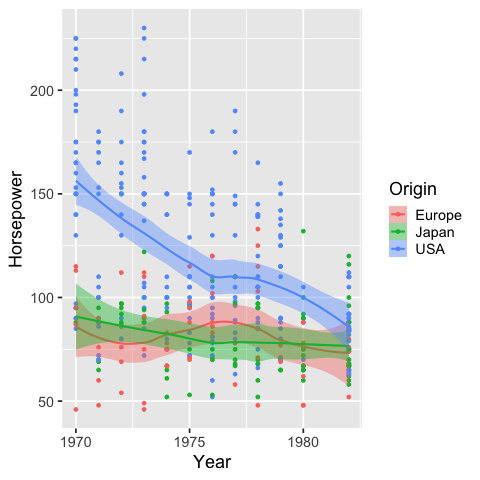

In [22]:
%%R -i cars
ggplot(cars) +
    aes(x = Year,
        y = Horsepower,
        color = Origin,
        fill = Origin) +
    geom_point() +
    geom_smooth()

#### `geom_smooth` (remove CI)
And also remove it.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



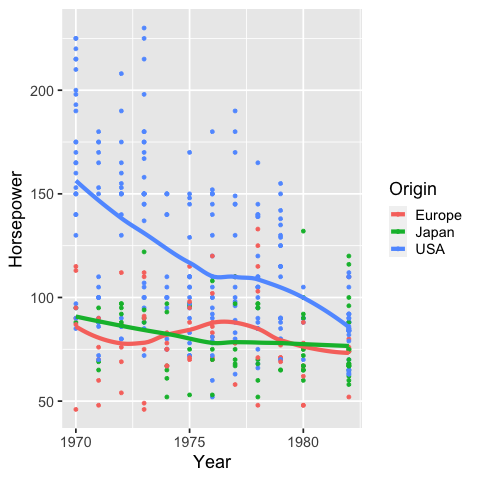

In [23]:
%%R -i cars
ggplot(cars) +
    aes(x = Year,
        y = Horsepower,
        color = Origin,
        fill = Origin) +
    geom_point() +
    geom_smooth(se = FALSE, size = 2)

#### `geom_smooth` (span)
Similar to the `bandwidth` in Altair,
you can set the `span` in `geom_smooth` 
to alter how sensitive the loess fit is to local variation.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



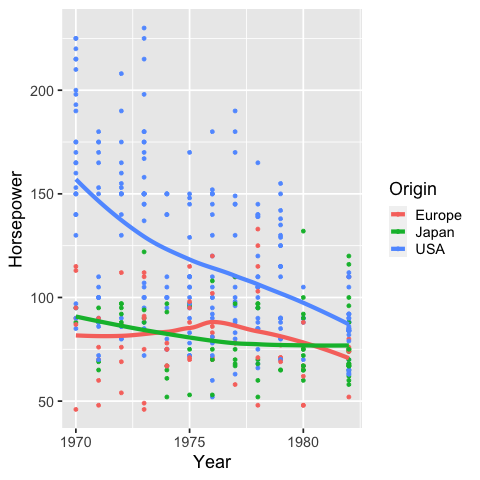

In [24]:
%%R
ggplot(cars) +
    aes(x = Year,
        y = Horsepower,
        color = Origin,
        fill = Origin) +
    geom_point() +
    geom_smooth(se = FALSE, size = 2, span = 1)

#### linear regression
If you wnat a linear regression instead of loess
you can set the method to `lm` (linear model).

R[write to console]: `geom_smooth()` using formula 'y ~ x'



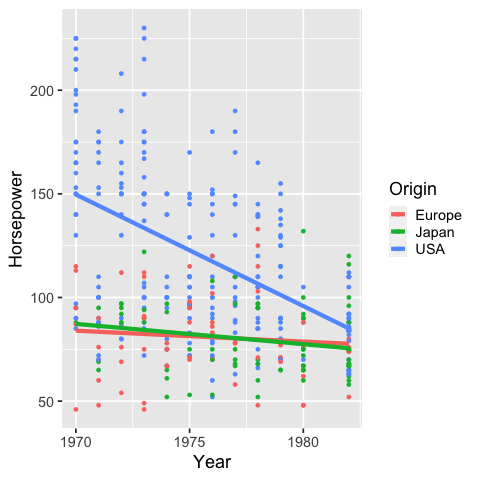

In [25]:
%%R
ggplot(cars) +
    aes(x = Year,
        y = Horsepower,
        color = Origin,
        fill = Origin) +
    geom_point() +
    geom_smooth(se = FALSE, size = 2, method = 'lm')

## 3. Confidence intervals

To show the confidence interval of the points as a band,
we can use `mark_errorband`.
By default this mark show the standard deviation of the points,
but we can change the `extent` to use bootstrapping on the sample data
to construct the 95% confidence interval of the mean.

### 1). Altair

#### `mark_errorband(extent='ci')`

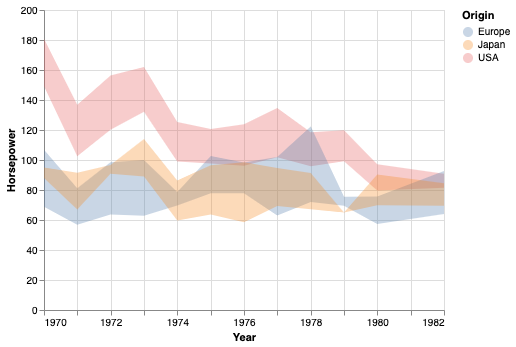

In [26]:
points.mark_errorband(extent='ci')

We can add in the mean line.

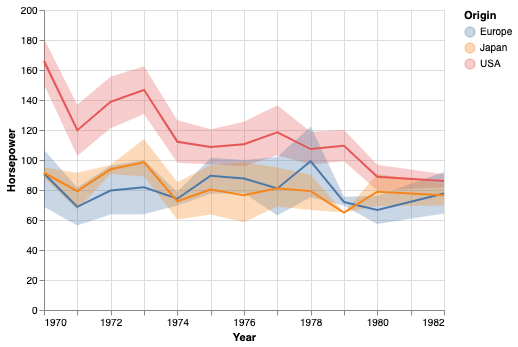

In [27]:
points.mark_errorband(extent='ci') + points.encode(y='mean(Horsepower)').mark_line()

#### `mark_errorband()` for SD
We can use `mark_errorbar` to show the standard deviation or confidence interval around a single point.

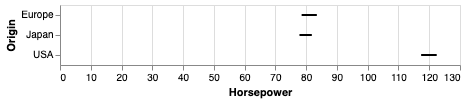

In [36]:
(
    alt.Chart(cars)
    .mark_errorbar(rule=alt.LineConfig(size=2))
    .encode(x="Horsepower", y="Origin")
)

Also here,
it is helpful to include an indication of the mean.

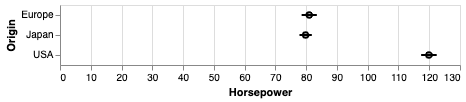

In [39]:
err_bars = (
    alt.Chart(cars)
    .mark_errorbar(rule=alt.LineConfig(size=2))
    .encode(x="Horsepower", y="Origin")
)

err_bars + err_bars.mark_point(color="black").encode(x="mean(Horsepower)")

#### CI + ticks
An particularly usful visualization 
is to combine the above with an indication of the distribution of the data,
e.g. as a faded violinplot in the background
or as faded marks for all observations.
This gives the reader a chance to study the raw data
in addition to seeing the mean and its certainty.

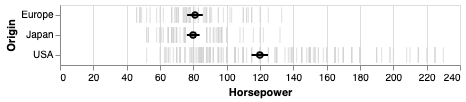

In [42]:
err_bars = (
    alt.Chart(cars)
    .mark_errorbar(extent="ci", rule=alt.LineConfig(size=2))
    .encode(x="Horsepower", y="Origin")
)



(
    err_bars.mark_tick(color="lightgrey")
    + err_bars
    + err_bars.mark_point(color="black").encode(x="mean(Horsepower)")
)

### 2). ggplot

#### CI - `geom_ribbon`
In ggplot, we can create confidence bands via `geom_ribbon`.
Previously we have passed specific statistic summary functions to the `fun` parameter,
but here we will use `fun.data` because we need both the lower and upper bond 
of where to plot the ribbon.
Whereas `fun` only allows functions that return a single value which decides where to draw the point on the y-axis
(such as `mean`),
`fun.data` allows functions to return three values (the min, middle, and max y-value).
The `mean_cl_boot` function is especially helpful here,
since it returns the upper and lower bound of the bootstrapped CI
(and also the mean value, but that is not used by `geom_ribbon`).

You need the `Hmisc` package installed in order to use `mean_cl_boot`,
if you don't nothing will show up but you wont get an error,
so it can be tricky to realize what is wrong.

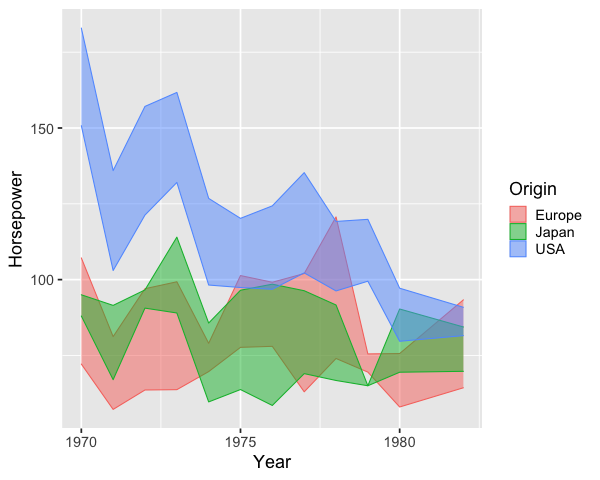

In [43]:
%%R -w 600
ggplot(cars) +
    aes(x = Year,
        y = Horsepower,
        color = Origin,
        fill = Origin) +
    geom_ribbon(stat = 'summary', fun.data = mean_cl_boot, alpha=0.5, color = NA)
    # `color = NA` removes the ymin/ymax lines and shows only the shaded filled area

We can add a line for the mean here as well.

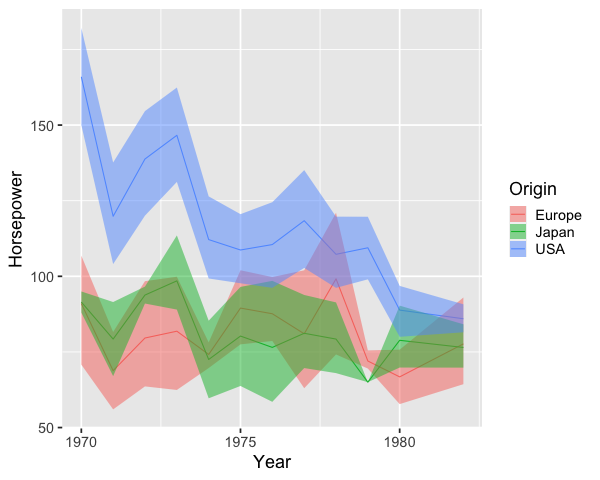

In [32]:
%%R -w 600
ggplot(cars) +
    aes(x = Year,
        y = Horsepower,
        color = Origin,
        fill = Origin) +
    geom_line(stat = 'summary', fun = mean) +
    geom_ribbon(stat = 'summary', fun.data = mean_cl_boot, alpha=0.5, color = NA)

#### `geom_pointrange`
To plot the confidence interval around a single point,
we can use `geom_pointrange`,
which also plots the mean
(so it uses all three values return from `mean_cl_boot`).

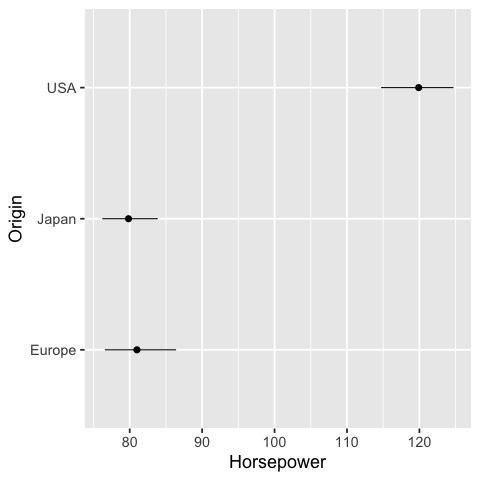

In [33]:
%%R
ggplot(cars) +
    aes(x = Horsepower,
        y = Origin) +
    geom_pointrange(stat = 'summary', fun.data = mean_cl_boot)

#### CI + ticks
And finally we can plot the observations in the backgound here.

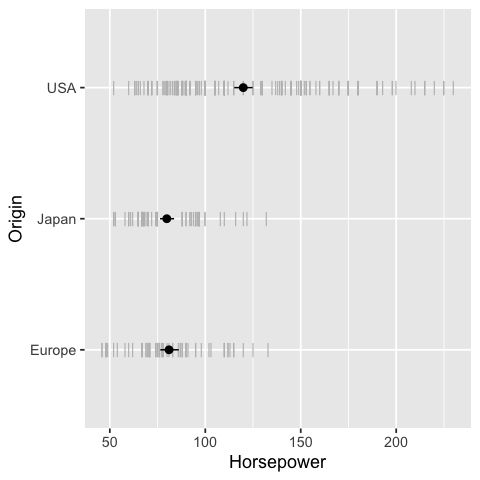

In [34]:
%%R
ggplot(cars) +
    aes(x = Horsepower,
        y = Origin) +
    geom_point(shape = '|', color='grey', size=5) +
    geom_pointrange(stat = 'summary', fun.data = mean_cl_boot, size = 0.7)

#### CI + violin

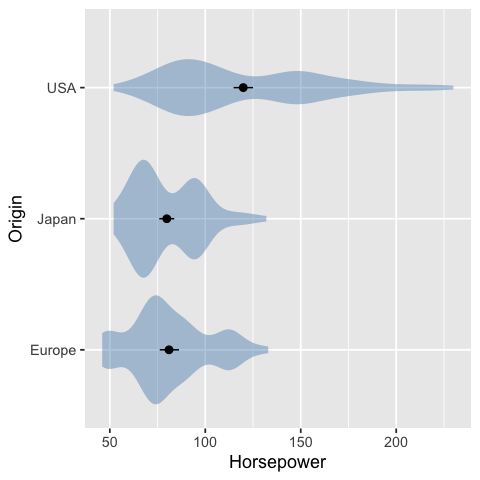

In [35]:
%%R
ggplot(cars) +
    aes(x = Horsepower,
        y = Origin) +
    geom_violin(color = NA, fill = 'steelblue', alpha = 0.4) +
    geom_pointrange(stat = 'summary', fun.data = mean_cl_boot, size = 0.7)